---
layout: post 
comments: true 
tags: dementia clustering data-visualization data-interpretation R-stats RNA-seq
title: Cracking Open Clusters with Clouds
---

In [1]:
setwd('..')

["Cloud" visualizations, or "tag clouds"](https://en.wikipedia.org/wiki/Tag_cloud) are great ways of summarizing a bunch of data when a frequency table or list would be too unwieldy or confusing. They're most commonly encountered in the context of text mining but we could really use them with anything where there's a large number of categories or bins. In the most common version of these visualizations, the size of category or bin name (or word, in the case of word clouds) is indicative of its frequency. Here's an example using the text of a favorite poem of mine, [*The Love Song of J. Alfred Prufrock*](https://www.poetryfoundation.org/poetrymagazine/poems/44212/the-love-song-of-j-alfred-prufrock) by T.S. Eliot (made using a free, online word cloud generator available [here](https://www.wordclouds.com/)).

![Prufrock Cloud](https://i.imgur.com/kSKoTor.png)

In [my last post](http://blog.vislaywade.com/clustering-feature-engineering-dataset-construction/), we clustered genes that we [identified as differentially-expressed in dementia](http://blog.vislaywade.com/EDA-gene-expression-data-part-3-results-visualizations/) in samples from a region of the brain critical for memory formation (the hippocampus) using the [$k$-medoids](https://en.wikipedia.org/wiki/K-medoids) partitioning method. We also discussed gene ontologies, or terms that tell us about where gene products are found in cells, what they do, and which "big picture" biological processes they participate in. I introduced you to the `mygene` package for R that has query functions for an [open-source database](http://mygene.info/) of gene ontology information. We used it to take a peak at what the medoids we identified (and want to use as new features for models of dementia risk) do and where they might be found in cells.  

In this post, we'll make some "term clouds" using the `wordcloud` package for R to help crack open the three clusters we made for hippocampus dementia-associated genes. Genes that participate in the same or related biological processes tend to have similar expression patterns and may cluster together. We'll use term clouds to get a sense of whether or not this is the case for the three clusters of genes that we found to potentially be involved in dementia. Maybe there are different processes represented in the different clusters. We'll find out!  

#### On tap for this post:  
1. *Load Libraries & Data* - If you're running the Jupyter notebook copy of this post from within a cloned copy of the [project repo on GitHub](https://github.com/brilliantFire/Allen-aging-dementia-TBI), you have everything you need to make this work. Alternatively, you can download the files directly from the repo `data` folder and modify the code to read the .Rds files from the folder you put them in.  

2. *$k$-medoid Cluster Assignments* - We'll run the CLARA algorithm and grab lists of the genes in each cluster.  

3. *Query `mygene.info` For Biological Process Terms* - We'll make lists of the terms associated with the genes in each cluster.  

4. *Term Clouds* - We'll look at the biological processes associated with the genes in each cluster.  

Let's get started!

### Load Libraries & Data  
First, let's get some libraries loaded. 

In [2]:
library(cluster)        # k-medoids via CLARA
library(mygene)         # To query mygene.info for biological process terms
library(wordcloud)      # For clouds of annotation terms/words

Warning message:
"package 'cluster' was built under R version 3.4.4"Warning message:
"package 'mygene' was built under R version 3.4.2"Loading required package: GenomicFeatures
Warning message:
"package 'GenomicFeatures' was built under R version 3.4.3"Loading required package: BiocGenerics
Warning message:
"package 'BiocGenerics' was built under R version 3.4.2"Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, leng

Now, we'll read in the data. This includes the normalized tables of gene expression levels (in fragments per kilobase million, or FPKM), some information about the samples (including which ones come from the hippocampus), and lists of the differentially-expressed-in-dementia genes we identified for each of the four brain regions in the dataset.   

In [3]:
# load normalized FPKM values, sample info, DE gene lists for brain regions, annotations
fpkm_table <- readRDS(file='data/normalized_fpkm_matrix.Rds')
sample_info <- readRDS(file='data/sample_info.Rds')
brain_reg_sig_genes <- readRDS(file='data/brain_reg_sig_genes.Rds')

# make FPKM numeric matrix
fpkm_mat <- as.matrix(fpkm_table)
class(fpkm_mat) <- 'numeric'

# standardize
fpkm_standard_mat <- t(scale(t(fpkm_mat)))

# pull out individual brain region DE gene list
hip_genes <- brain_reg_sig_genes$hip_genes

# subset FPKM matrix to just HIP samples and HIP DE genes
hip_samples <- sample_info$rnaseq_profile_id[which(sample_info$structure_acronym == 'HIP')]
hip_data <- fpkm_standard_mat[hip_genes, colnames(fpkm_standard_mat) %in% hip_samples]

### $k$-medoid Cluster Assignments  
CLARA is an algorithm for doing $k$-medoids clustering. We'll instruct the `clara()` method to find $k=3$ clusters for the 277 differentially-expressed genes we found in hippocampus samples.  

In [4]:
# set an RNG seed for reproducibility
set.seed(424)

# run CLARA on HIP FPKM values
hip_final_clara <- clara(hip_data, k=3, metric = 'euclidean', 
                         samples=1000, sampsize=250, pamLike=TRUE)

Here's a plot of the data along the first two principal components, which allows us to visualize the clusters.

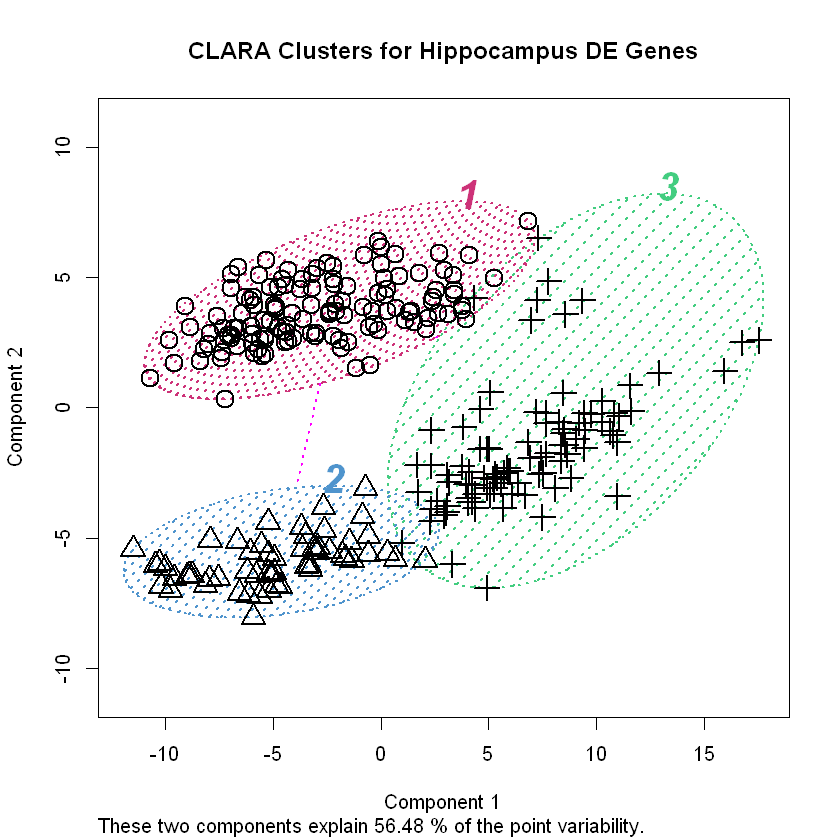

In [5]:
clusplot(hip_final_clara, color=TRUE, shade=TRUE, 
         labels=4, col.txt='black', col.p='black', 
         col.clus=c('seagreen3', 'steelblue3', 'violetred3', 'sienna3'), 
         cex=2, main = 'CLARA Clusters for Hippocampus DE Genes', 
         ylim=c(-11,11), lwd=2, lty=3)

The `clara` object contains many useful things. 

In [6]:
names(hip_final_clara)

[1] "sample"     "medoids"    "i.med"      "clustering" "objective" 
 [6] "clusinfo"   "diss"       "call"       "silinfo"    "data"

In the [last post](http://blog.vislaywade.com/clustering-feature-engineering-dataset-construction/), we accessed the `medoids` attribute to make new variables for future models of dementia risk. This time, we'll get the cluster assignments for each gene from the `clustering` attribute. The row names for our original dataframe (and thus for everything from the `clara` object) are Entrez Gene numbers that are unique identifiers of the genes. To get lists of the genes in each cluster, we'll simply get the row names that are associated with the different cluster assignments using `which()`.  

In [7]:
# create cluster assignment dataframe
hip_clusters <- data.frame(cluster_assignment=hip_final_clara$clustering)

# list of genes in each cluster
hip_genes01 <- rownames(hip_clusters)[which(hip_clusters$cluster_assignment == 1)]
hip_genes02 <- rownames(hip_clusters)[which(hip_clusters$cluster_assignment == 2)]
hip_genes03 <- rownames(hip_clusters)[which(hip_clusters$cluster_assignment == 3)]

### Query the [`mygene.info`](http://mygene.info/) Database for Biological Process Terms  
The `queryMany()` methods from the `mygene` package let's look up many genes at one time. We set the `scopes` argument equal to whatever it is we're looking the genes up by, which in our case in the Entrez Gene ID number. We'll tell it to return the gene ontologies (GO).  

In [8]:
# query mygene.info
hip_query01 <- queryMany(hip_genes01, scopes='entrezgene', fields='go', species='human')
hip_query02 <- queryMany(hip_genes02, scopes='entrezgene', fields='go', species='human')
hip_query03 <- queryMany(hip_genes03, scopes='entrezgene', fields='go', species='human')

Finished
Finished
Finished


The `mygene.info` database is a "noSQL" ElasticSearch database where each gene has a file (in [JSON](https://en.wikipedia.org/wiki/JSON) format) full of information. When you query this database with R, the default result is a dataframe containing nested lists (in Python, these would be nested dictionaries). 

In [9]:
head(hip_query01)

DataFrame with 6 rows and 6 columns
        query         _id   X_score           go.BP           go.CC
  <character> <character> <numeric>          <list>          <list>
1       25937       25937  22.01014 IEA,IEA,IEA,... IDA,NAS,IDA,...
2   105378049   105378049  22.01014                                
3       57722       57722  22.00936                  IEA,IEA,CC,...
4        7273        7273  22.01098 TAS,IMP,NAS,... IDA,TAS,TAS,...
5        2006        2006  21.21801  IMP,IC,TAS,... TAS,TAS,HDA,...
6       25959       25959  22.00982 IBA,IDA,IEA,... IBA,IDA,IDA,...
                  go.MF
                 <list>
1          MF,MF,MF,...
2                      
3                      
4          MF,MF,MF,...
5          MF,MF,MF,...
6 MF,IPI,GO:0005515,...

The last three columns of the query dataframe contain lists of biological process (BP), cellular component (CC), and molecular function (MF) information for each gene. A single gene can take part in many biological processes, for example. Let's take a look at part of the BP dataframe for the first gene in the first cluster.

In [17]:
head(hip_query01[1, 'go.BP'][[1]])

evidence,gocategory,id,term,pubmed
IEA,BP,GO:0000122,negative regulation of transcription by RNA polymerase II,NULL
IEA,BP,GO:0001649,osteoblast differentiation,NULL
IEA,BP,GO:0001894,tissue homeostasis,NULL
IMP,BP,GO:0001933,negative regulation of protein phosphorylation,20412773
IEA,BP,GO:0003015,heart process,NULL
NAS,BP,GO:0006355,"regulation of transcription, DNA-templated",11118213


This not only provides us with the name of the biological process (`term`) but with information about how it was determined to participate in that process (encoded in [`evidence`](http://www.geneontology.org/page/guide-go-evidence-codes)) and the peer-reviewed publications (if any) in the scientific literature ([`pubmed`](https://www.ncbi.nlm.nih.gov/pubmed/)) where we can read about the experiments providing that evidence.  

The following one-liners pull out the BP terms for each gene and generate one long list of terms for each of the three clusters. Let's break these down:  

* First, we use `lapply()` to extract the single `term` columns from inside each gene's record we pulled from the database.  
* Next, we `unlist()` the list of `term` columns to concatenate them into a single list of terms.  
* Finally, we wrap the entire thing in a `data.frame()` and set the column name as `bp_terms`.  

In [11]:
# biological process (BP) gene ontology terms for each cluster
hip_cluster01_bp_terms <- data.frame(bp_terms=unlist(lapply(hip_query01$go.BP, function(x) x$term)))
hip_cluster02_bp_terms <- data.frame(bp_terms=unlist(lapply(hip_query02$go.BP, function(x) x$term)))
hip_cluster03_bp_terms <- data.frame(bp_terms=unlist(lapply(hip_query03$go.BP, function(x) x$term)))

Let's a have quick look at the first few terms for cluster #1.  

In [12]:
head(hip_cluster01_bp_terms)

bp_terms
negative regulation of transcription by RNA polymerase II
osteoblast differentiation
tissue homeostasis
negative regulation of protein phosphorylation
heart process
"regulation of transcription, DNA-templated"


### Term Clouds  
We're almost ready to make our cloud visualizations but, first, we need to get the frequencies for each of the terms. We'll do that using `table()`. 

In [13]:
# make tables of BP terms for each cluster
hip_terms01_table <- table(hip_cluster01_bp_terms$bp_terms)
hip_terms02_table <- table(hip_cluster02_bp_terms$bp_terms)
hip_terms03_table <- table(hip_cluster03_bp_terms$bp_terms)

In constructing our term clouds, we'll tell `wordcloud()` to use the names of the categories in the table as the "words" and the values inside as the frequencies. The `wordcloud` package let's us customize a wide variety of settings. For the first cluster, we'll tell it to plot 75 terms (`max.words`) with at least 2 copies in the list (`min.freq`). Along with the size of the words, we can also indicate how many of each term there is by color. In the examples below, the most frequent terms in the cluster are red, followed by blue and then black.  

Here's the cloud for the BP terms associated with hippocampus gene cluster #1.

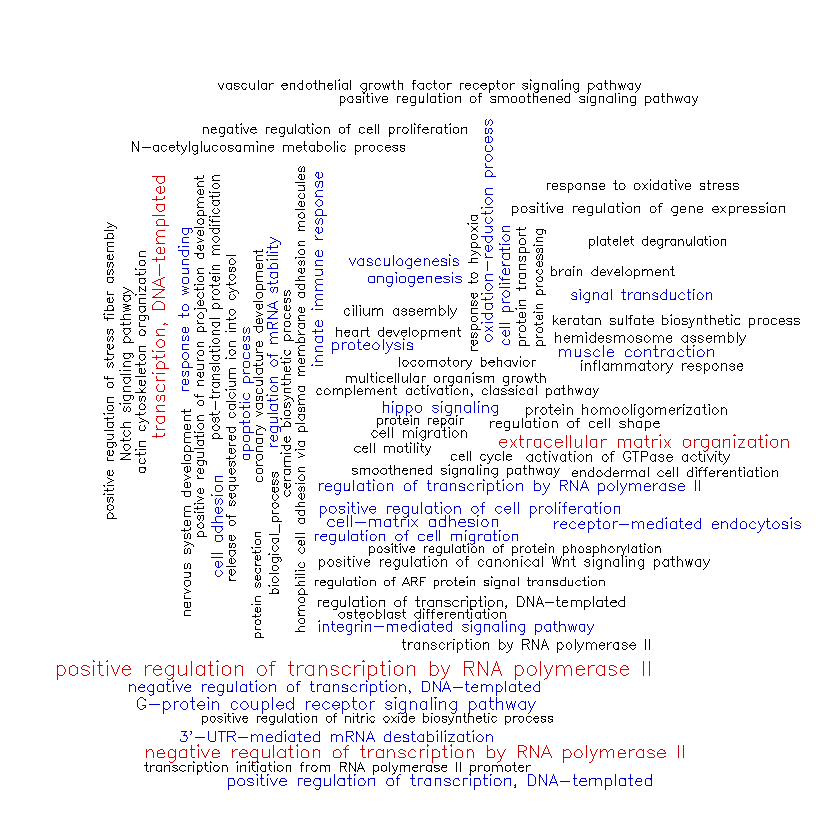

In [14]:
set.seed(412)

# BP "term cloud" for cluster #1...
wordcloud(names(hip_terms01_table), as.numeric(hip_terms01_table), 
          scale=c(1.1, .6), min.freq=2, max.words=75, random.order=T, 
          rot.per=.25, colors=c('black', 'blue3', 'red3'), 
          vfont=c('sans serif','plain'))

The genes in cluster #1 appear to be most strongly associated with the process of transcription and its regulation ("positive regulation of transcription by RNA polymerase II", "regulation of mRNA stability", etc.). They also seem to be associated with processes involving the extracellular matrix, such as cell adhesion and proliferation ("extracellular matrix organization", "cell-matrix adhesion", "regulation of cell migration", etc.). There appears to be some involvement of these genes in muscle contraction and vascular development ("muscle contraction", "angiogenesis", "vasculogenesis", etc.).  

Let's have a look at cluster #2.

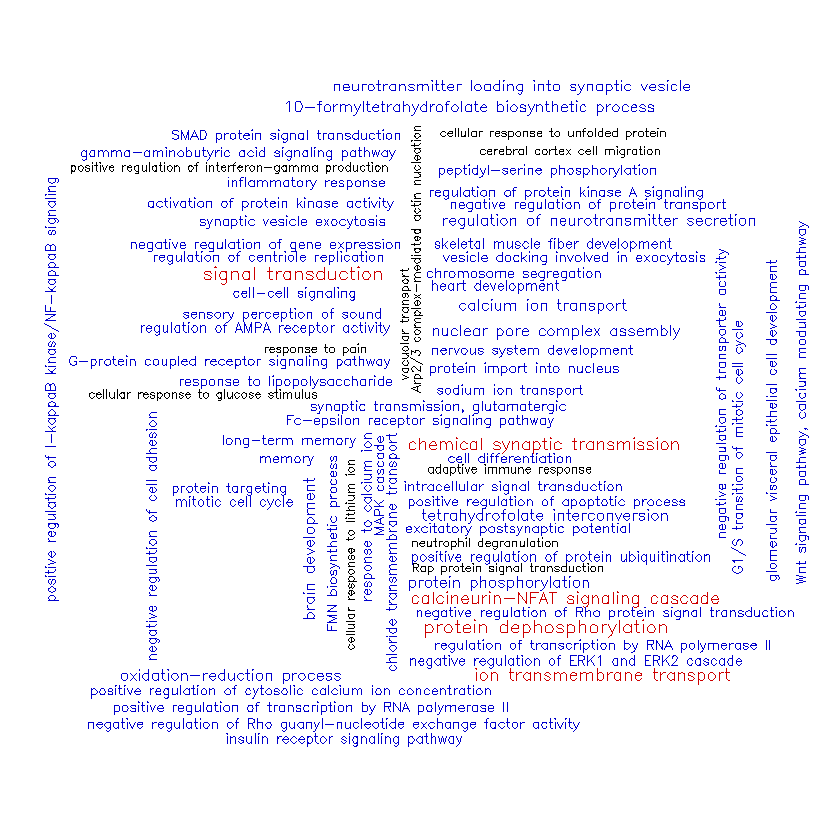

In [15]:
set.seed(412)

# ...for cluster #2...
wordcloud(names(hip_terms02_table), as.numeric(hip_terms02_table), 
          scale=c(1, .55),min.freq=1, max.words=75, random.order=T, 
          rot.per=.25, colors=c('black', 'blue3', 'red3'), 
          vfont=c('sans serif', 'plain'))

Very interesting! In contrast to the genes in cluster #1, those in cluster #2 seem to be strongly associated with communication between brain cells ("chemical synaptic transmission", "ion transmembrane transport", "neurotransmitter loading into synaptic vesicles", "excitatory postsynaptic potential", etc.) as well as intracellular signaling pathways ("signal transduction", "protein dephosphorylation", "calcineurin-NFAT signaling cascade", etc.). We might have expected cluster #2's genes to be involved in different biological processes than cluster #1 considering how well separated they are in the space defined by the first two principal components (see plot above). 

Finally, here's cluster #3.

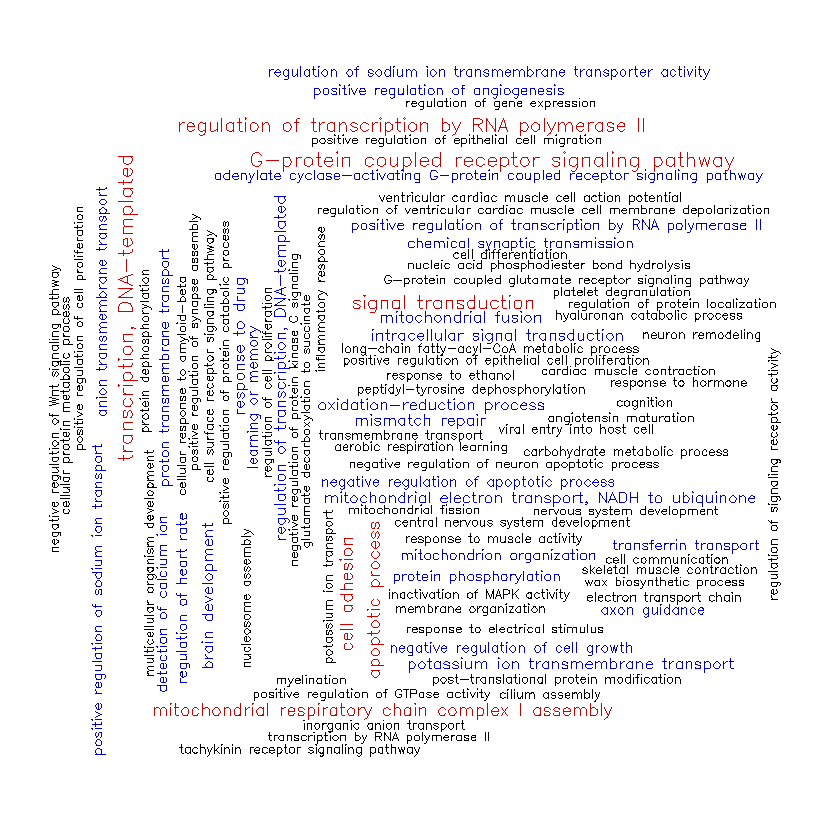

In [16]:
set.seed(412)

# ...and cluster #3
wordcloud(names(hip_terms03_table),as.numeric(hip_terms03_table), 
          scale=c(1.1, .5),min.freq=2, max.words=100, random.order=T, 
          rot.per=.25, colors=c('black', 'blue3', 'red3'), 
          vfont=c('sans serif','plain'))

Cluster #3 looks similar to cluster #1 in some ways. It shares cluster #1's participation in signal transduction, transcription, and cell adhesion, but includes a higher frequency of terms associated with mitochondrial structure/function (such as "mitochondrial respiratory chain complex I assembly", "mitochondrion organization", and "mitochondrial fusion"). Cluster #3 also has genes involved in regulating ion transport across cell membranes ("regulation of sodium ion transmembrane transporter activity", "proton transmembrane transport", "potassium ion transmembrane transport", etc.).

#### Take-Aways  
These cloud visualizations are really helpful in investigating whether the different clusters we put our dementia genes in correspond to different biological processes. While there is some overlap between the biological processes represented in all three clusters, and especially between clusters #1 and #3, each appear to have significant differences. Having some idea of these differences could help in interpretting the results of models that use the medoids of these clusters as features.  

As always, thanks for reading and happy coding :)